# Partial Dependence Plots with PDPBox

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

This notebook was created by [Sal J.M](https://www.linkedin.com/in/salim-j-m-a04534114/). Thank you so much for your contribution Sal!!

The PDPBox package extends the capabilities of Partial Dependence Plots (PDPs) and offers several advantages over traditional PDPs. Some of the advantages of using the PDPBox package include:

 - Enhanced Visualization: PDPBox provides more visually informative and customizable PDP plots. It offers richer visualization options.

 - Customization: PDPBox offers greater control over the appearance and aesthetics of the PDP plots. You can customize the color schemes, titles, labels, and more to tailor the visualizations to your specific needs and preferences.
 
 - Advanced Features: PDPBox includes "ICE" (Individual Conditional Expectation) plots, which provide insights into individual data point-level predictions and variations. This can be helpful for understanding the model's behavior at a granular level.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from feature_engine.encoding import OneHotEncoder

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
from xgboost import XGBClassifier

In [5]:
from pdpbox import pdp

### Load Titanic data

In [6]:
# The data can be accessed online.
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

In [7]:
data.shape

(1309, 14)

In [8]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


### Preprocess data

 - Please note that it's important to split the data before pre-processing. Here we don't do it for simplicity.

In [9]:
# Replace question mark by NaN
data = data.replace('?', np.nan)


# Extract the first letter from the variable cabin
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)


# capture letter from cabin
data["cabin"] = data["cabin"].str[0]

# cabin T is a rare label, we replace it with G
data.loc[data["cabin"] == "T", "cabin"] = "G"

# impute cabin and embarked
data.fillna({
    "cabin":"M",
    "embarked": "S",
}, inplace=True)

# set pclass', 'sibsp', 'parch' columns to data type int
data[['pclass', 'sibsp', 'parch']] = data[['pclass', 'sibsp', 'parch']].astype(int)

# set fare to data type float
data['fare'] = data['fare'].astype(float)
# impute fare with the median
data['fare'] = data['fare'].fillna(data['fare'].median())

# select the features of interest only
usecols = ["pclass", "sibsp", "parch", "sex", "fare", "embarked", "cabin", "survived", ]
data = data[usecols]

# OHE for categorical features
data = OneHotEncoder(drop_last=False).fit_transform(data)

### Split Data

In [10]:
X = data.drop(columns='survived')
y = data['survived']

In [11]:
X.shape, y.shape

((1309, 17), (1309,))

In [12]:
# separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


In [13]:
X_train.shape, X_test.shape

((916, 17), (393, 17))

In [14]:
y_train.shape, y_test.shape

((916,), (393,))

### Train XGBoost

In [15]:
# create xgboost classifier
xgbc = XGBClassifier(n_estimators=10,
                     max_depth=1,
                     random_state=3,)

# train xgboost
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

In [16]:
# predict to get the model performance
y_train_proba = xgbc.predict_proba(X_train)[:, 1]
y_test_proba = xgbc.predict_proba(X_test)[:, 1]

In [17]:
# train roc-auc
roc_auc_score(y_train, y_train_proba)

0.8301767645001736

In [18]:
# test roc-auc
roc_auc_score(y_test, y_test_proba)

0.8240556385155688

### XGBoost Feature Importance

 XGboost provides feature importance which can be used as a global interpretation method.

In [19]:
pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sex_female    0.551779
cabin_M       0.211860
pclass        0.169512
embarked_C    0.066848
cabin_C       0.000000
cabin_G       0.000000
cabin_A       0.000000
cabin_D       0.000000
cabin_E       0.000000
embarked_Q    0.000000
cabin_B       0.000000
sibsp         0.000000
embarked_S    0.000000
sex_male      0.000000
fare          0.000000
parch         0.000000
cabin_F       0.000000
dtype: float32

 - While this intrinsic Feature Importance method is a very useful interpretation method, that uncovers the most impactful features on the model prediction, it cannot show the relationship of a given feature with the target variable, for example:
     - Does the output of a model increase or decrease when a feature increase?
     - What is the nature of the relationship with the target? linear, non-linear, monotonic etc.
     - PDP tries to answer these questions by plotting the feature values on the x-axis and the model outputs on the y-axis

### PDP with PDPBox

#### PDP for Gender

In [20]:
# To use PDPbox to generate the plots, we start by creating a PDP analysis object using the PDPIsolate class.
# We can then obtain the analysis results in an object of type PDResults

# create a PDP analysis for sex_female
pdp_sex_female = pdp.PDPIsolate(
    model=xgbc, # specify the trained model here
    df=pd.concat([X_test, y_test], axis=1), # we give PDPIsolate the test data: features and target in the same frame
    model_features=X_test.columns, # here, we provide the names of the features used to train the model
    feature="sex_female", # we select the feature of interest, in this example it is sex_female
    feature_name="gender", # we can set a custom name for the target feature, we go with gender for instance.
)

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

 - PDPIsolate documentation link: https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html

#### Basic plot for Gender

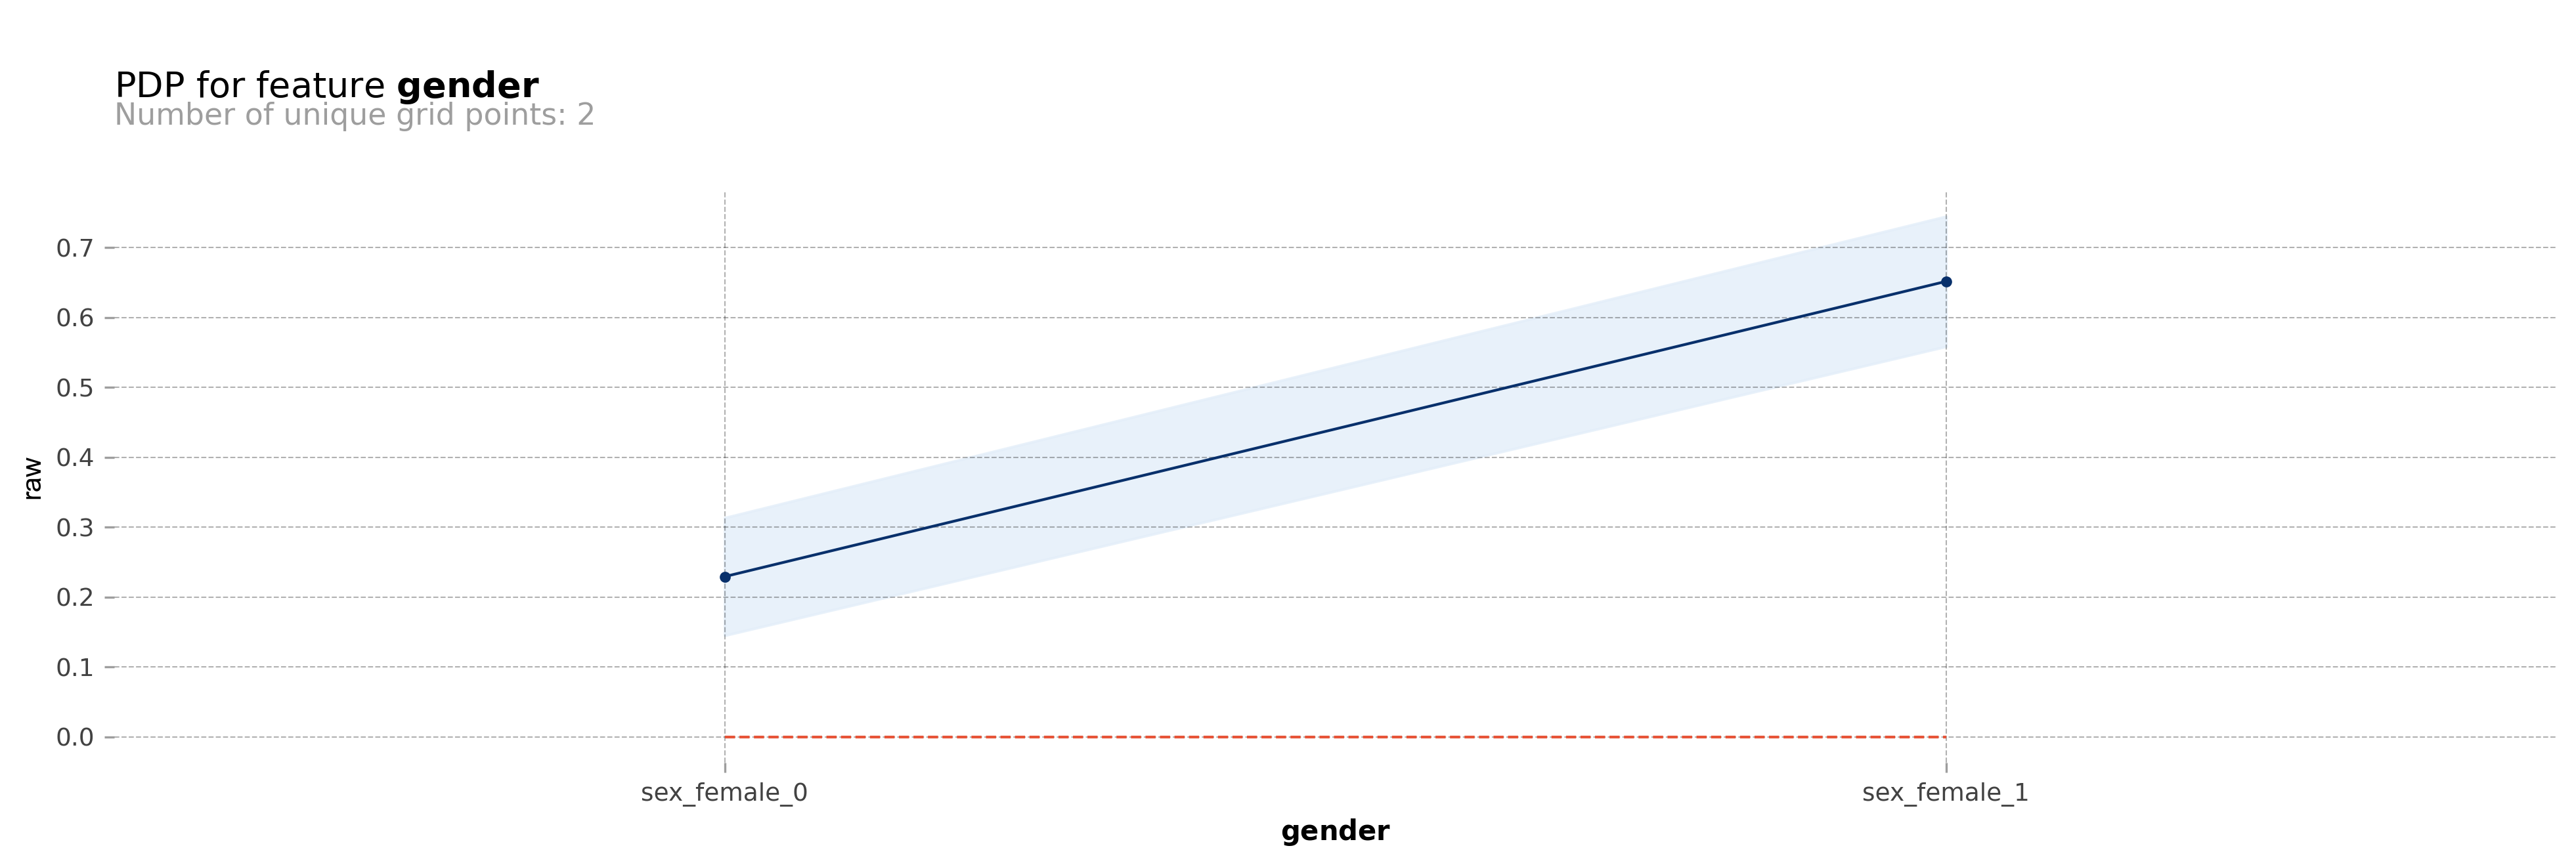

In [21]:
# At this point, we can use the Results object to generate a plot
fig, axes = pdp_sex_female.plot(
    center=False,
    plot_lines=False, # False for PDP, True will generate the ICE plots, we will see ICE in another notebook
    plot_pts_dist=False, # set this to True to see how the feature values are distributed, this will show on the x-axis
    to_bins=False, # set to True to discretize the feature values when the feature is continuous (not applicable here)
    engine='matplotlib', # set the engine to matplotlib, the other option is plotly
);

fig.set_figheight(5)

#### Centered plot for Gender

 - Both PDPBox and scikit-learn offer the option of centering the Y-axis of a PDP to 0.
 - This makes the PDP more interpretable and facilitate fair comparisons between features.
     - Centering makes it clear that changes in the feature value are associated with an increase (above 0) or a decrease (below 0) in the model's prediction. This provides a straightforward way to understand the direction and magnitude of the feature's effect.

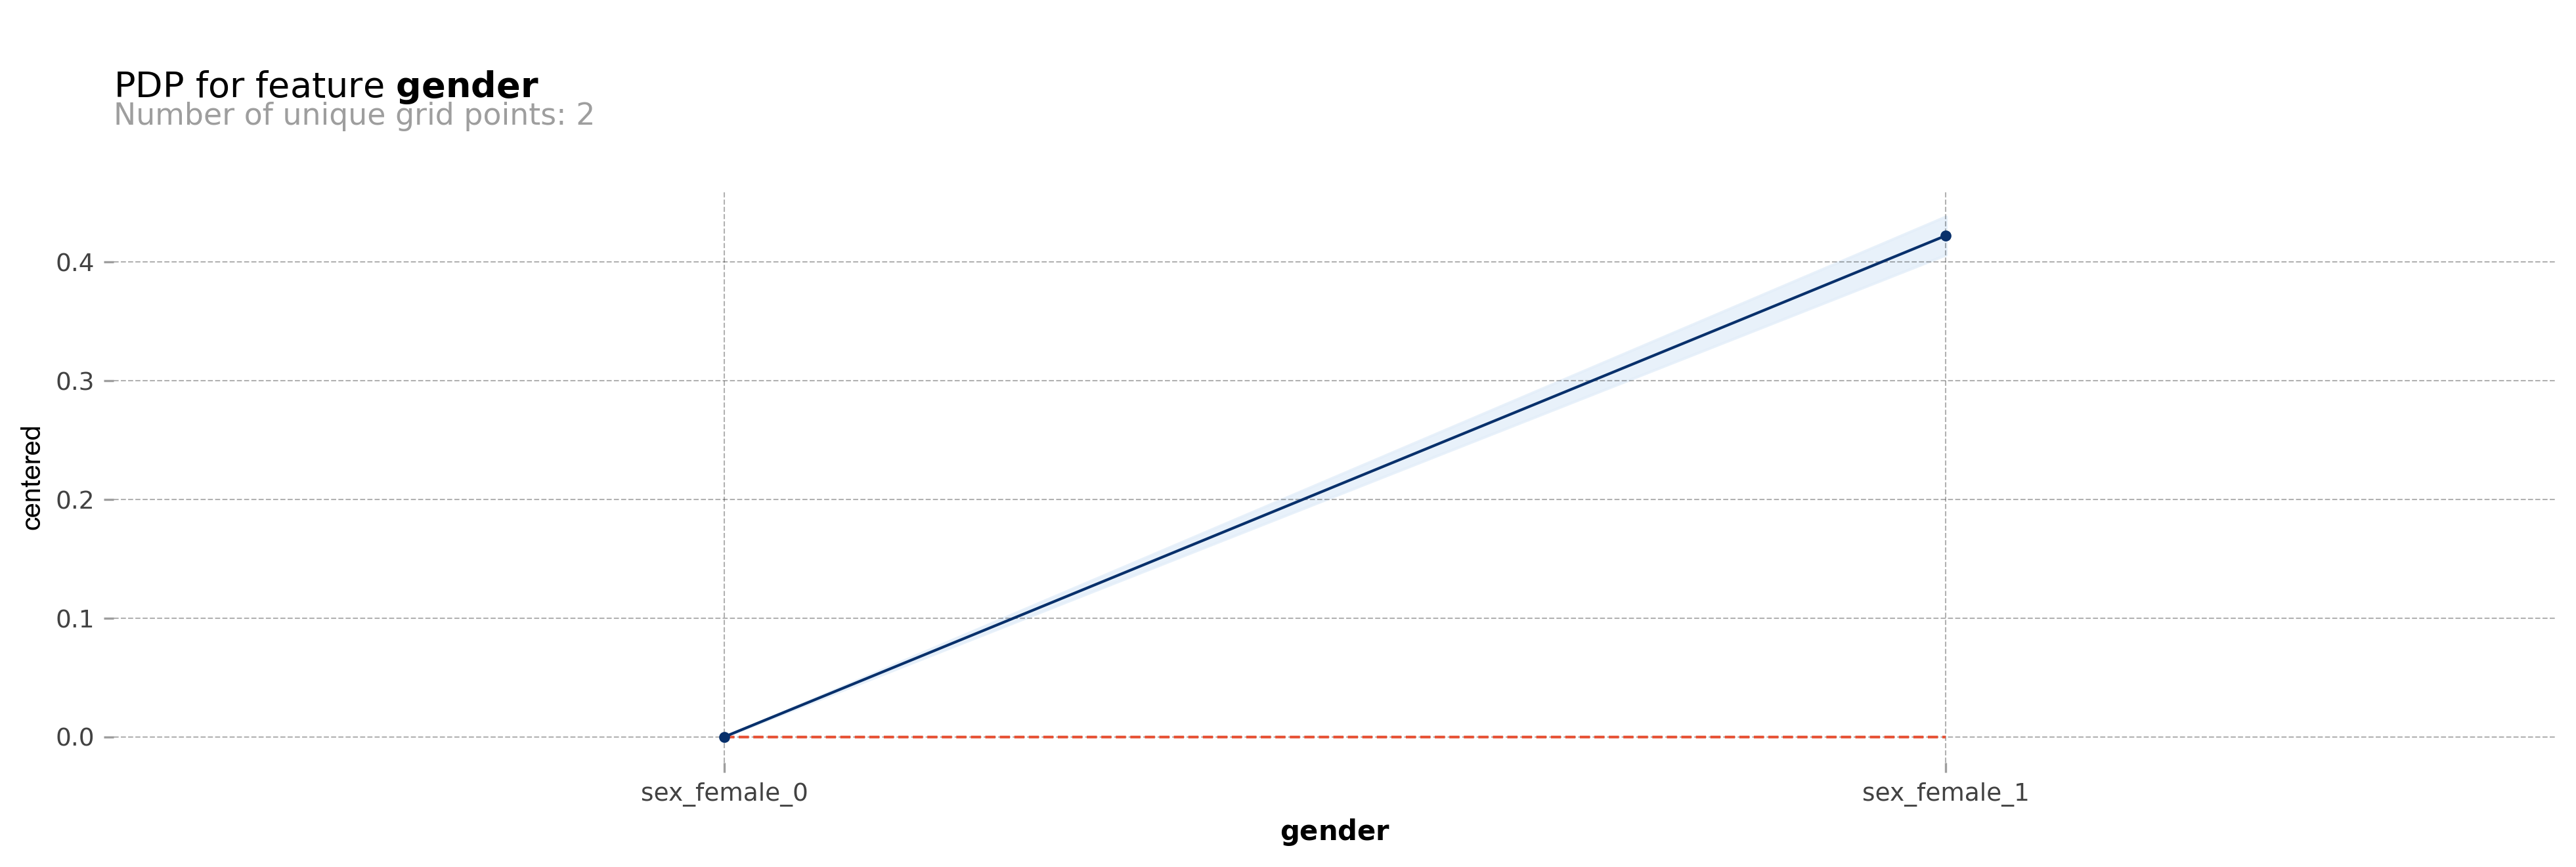

In [22]:
fig, axes = pdp_sex_female.plot(
    center=True, # set this to True
    plot_lines=False,
    plot_pts_dist=False, 
    to_bins=False, 
    engine='matplotlib', 
);
fig.set_figheight(5)

#### PDP with Feature distribution


 - Set the plot_pts_dist parameter to True to see the distribution of the feature as the cell below shows.
 - This can be valuable as:
     - more informative plot, and
     - Identification of sparse areas in the feature's distribution. This may indicate the presence of outliers, model sensitivity, and the need for potential feature engineering to improve the model's performance, especially in these sparse regions.
         

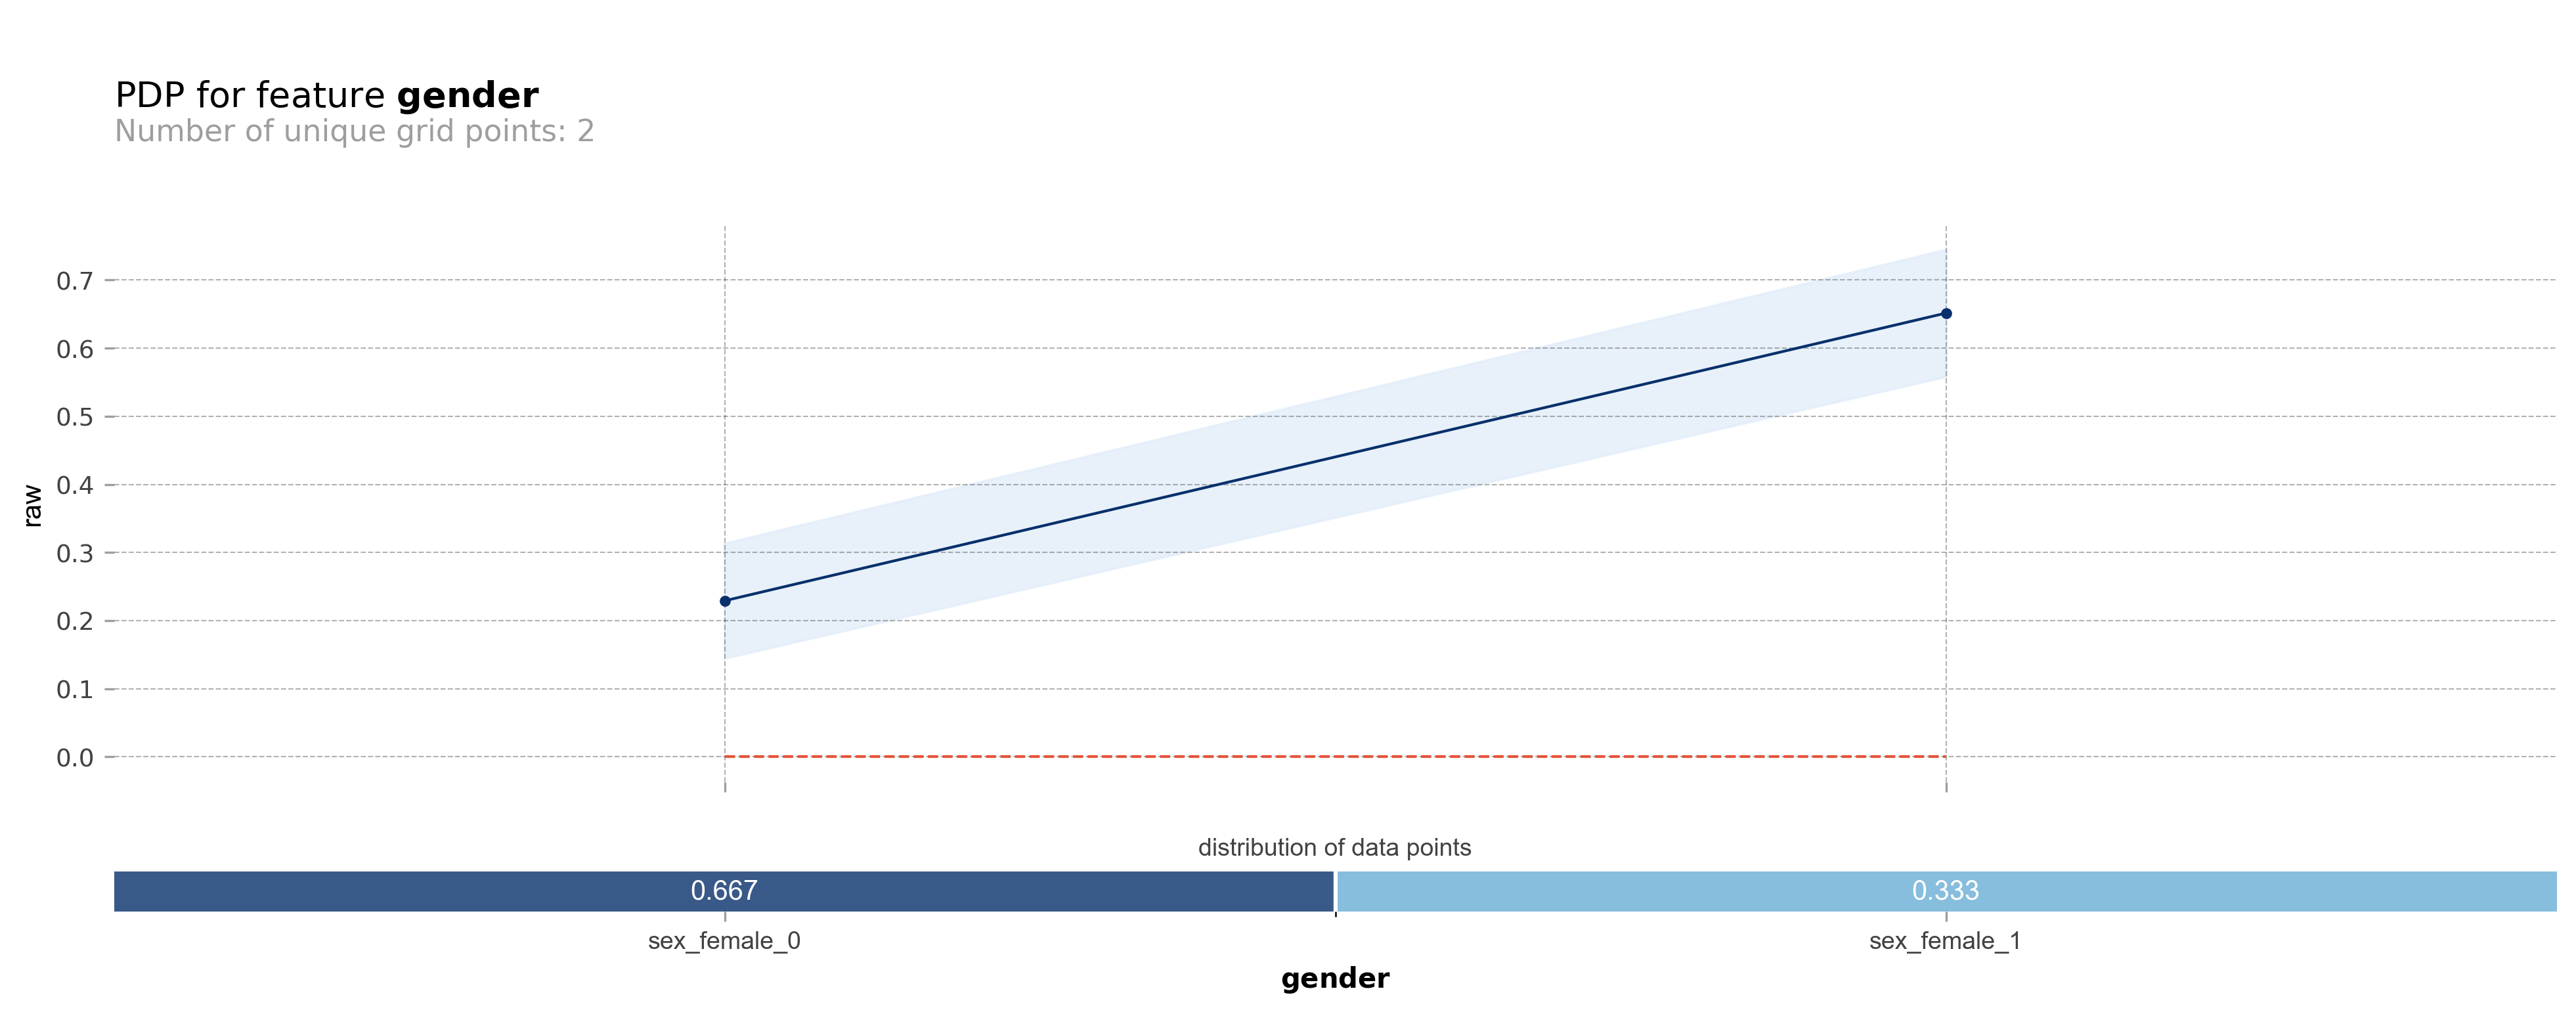

In [23]:
fig, axes = pdp_sex_female.plot(
    center=False,
    plot_lines=False, 
    plot_pts_dist=True, # set this to True 
    to_bins=False, 
    engine='matplotlib', 
);
fig.set_figheight(6)

In [24]:
# verify the fearture distribution
X_test['sex_female'].value_counts(normalize=True)

sex_female
0    0.666667
1    0.333333
Name: proportion, dtype: float64

### PDP for a continuous feature (fare)

  - We know fare was not an influencial feature in this model
  - We generate its PDP here to show how PDPbox plots continuous variables

In [25]:
# we generate a new PDPIsolate, this time for the fare variable
pdp_fare = pdp.PDPIsolate(
    model=xgbc,
    df=pd.concat([X_test, y_test], axis=1),
    model_features=X_test.columns,
    feature="fare",
    feature_name="fare",
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

 - PDP plot on continuous features can be rich and informative, we can set:
     - show_percentile to True to display these on the top of the feature
     -  plot_pts_dist to True to display the distribution along the x-axis
     -  to_bins to True to discretize the variable into bins and also display the variable intervals along the x-axis

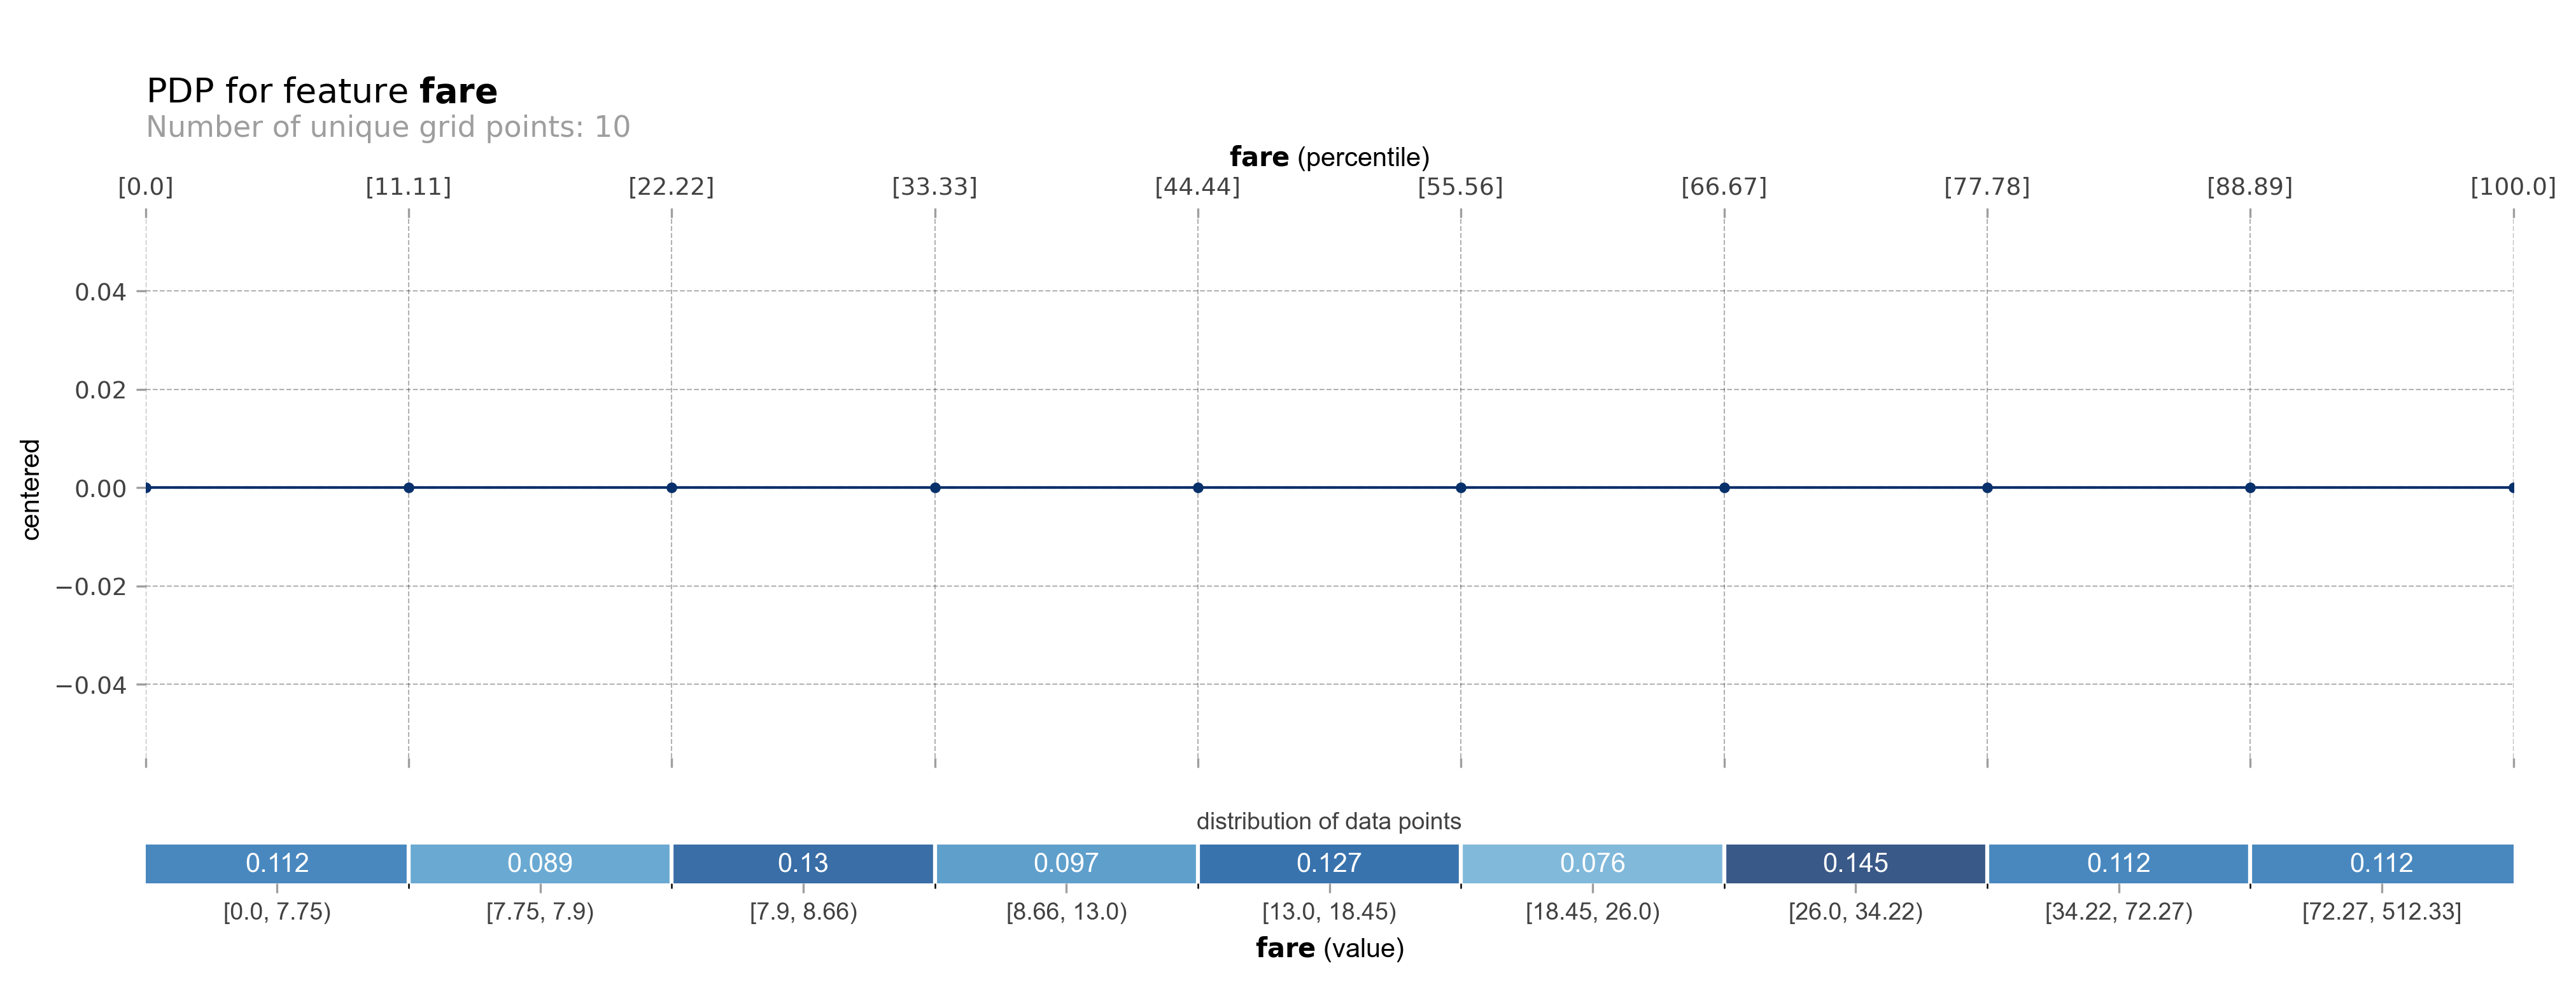

In [26]:
fig, axes = pdp_fare.plot(
    center=True,
    plot_lines=False, 
    show_percentile=True,
    plot_pts_dist=True,
    to_bins=True, 
    engine='matplotlib', 
);
fig.set_figheight(6)

### PDP for One Hot Encoded feature (cabin)

In [27]:
# get all One Hot Encoded features for cabin
# this list will then be used by PDPbox
cabin_features = sorted([c for c in X_test if c.startswith('cabin_')])

In [28]:
cabin_features

['cabin_A',
 'cabin_B',
 'cabin_C',
 'cabin_D',
 'cabin_E',
 'cabin_F',
 'cabin_G',
 'cabin_M']

In [29]:
pdp_cabin = pdp.PDPIsolate(
    model=xgbc,
    df=pd.concat([X_test, y_test], axis=1),
    model_features=X_test.columns,
    feature=cabin_features, # we set all the OHE features that correspond to cabin here
    feature_name="cabin", # we can set the name of the main variable here (before pre-processing)
)

obtain pred_func from the provided model.


  0%|          | 0/8 [00:00<?, ?it/s]

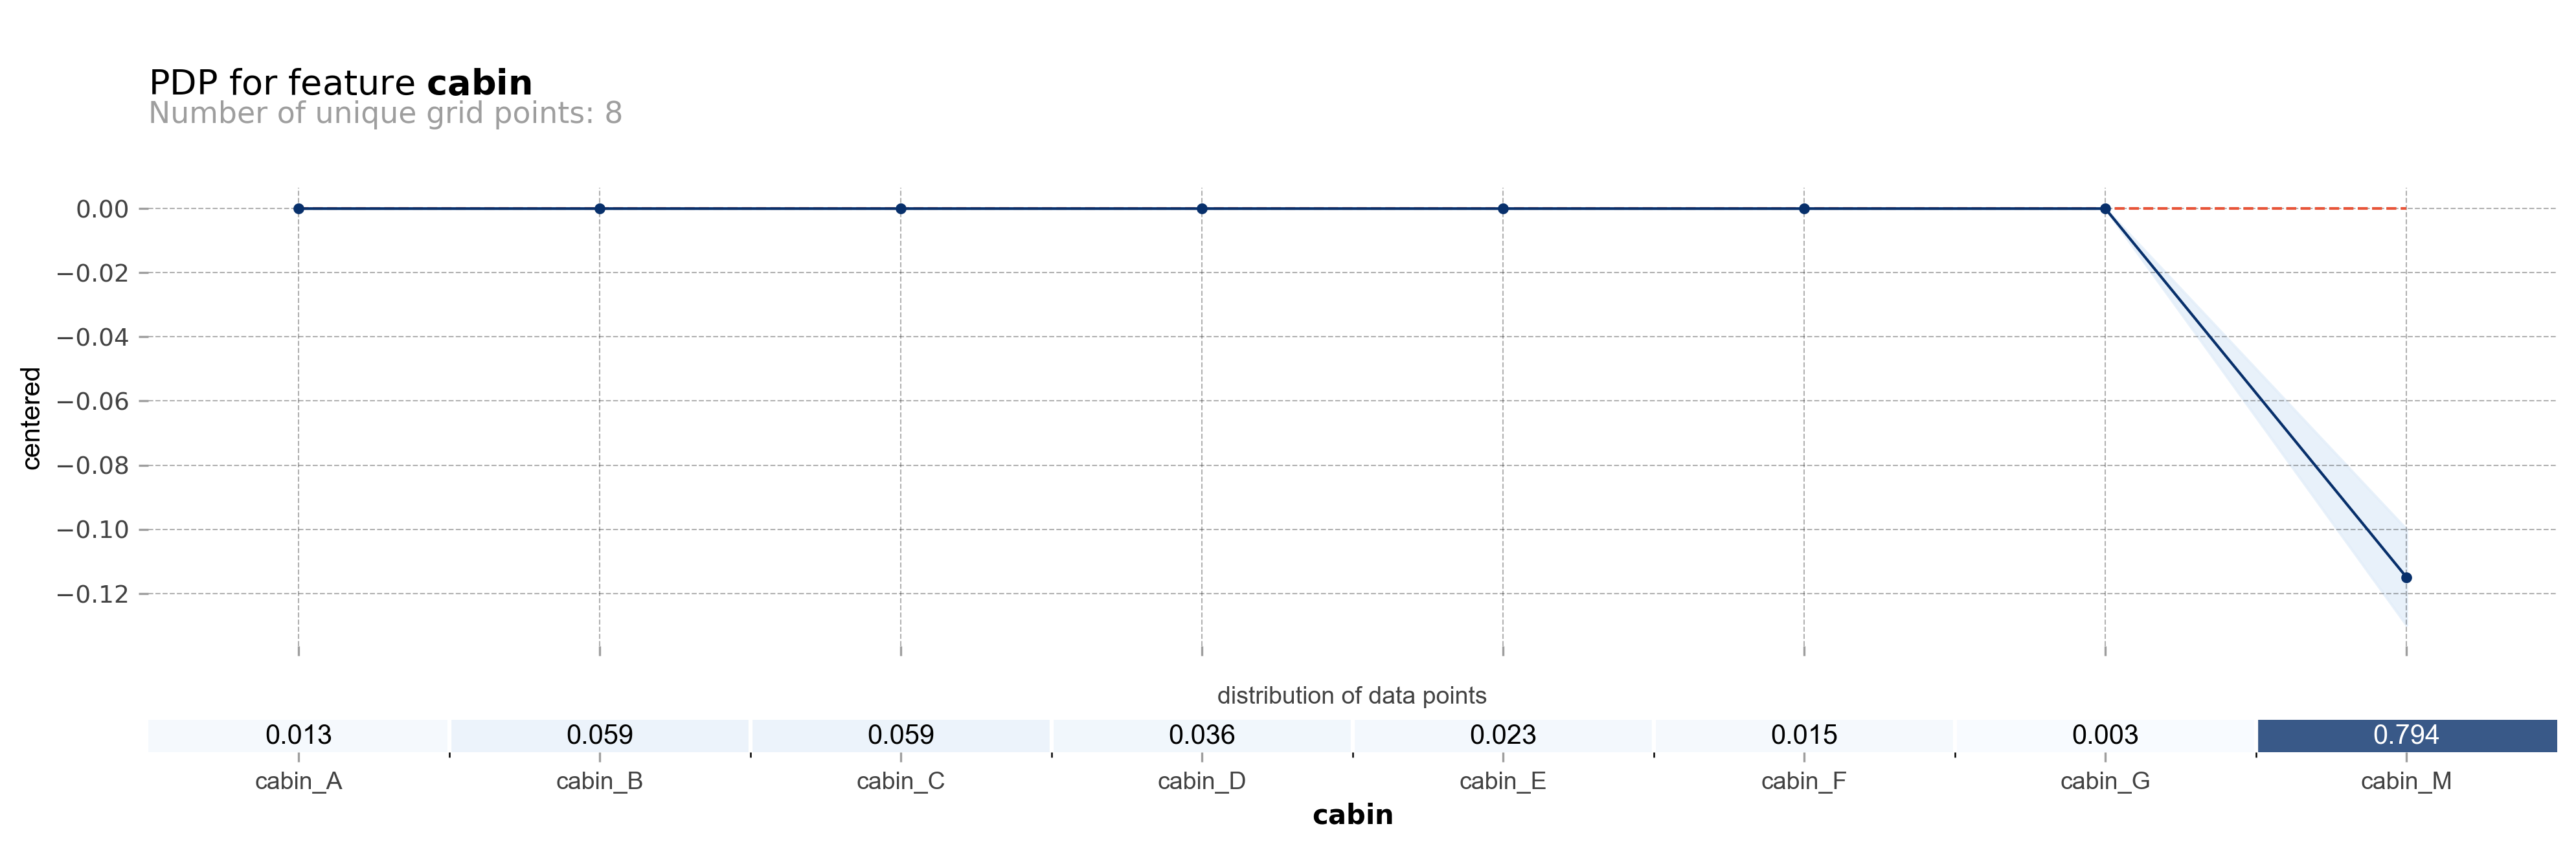

In [30]:
fig, axes = pdp_cabin.plot(
    center=True,
    plot_lines=False,
    plot_pts_dist=True, 
    to_bins=False,
    engine='matplotlib',
);
fig.set_figheight(5)

 - In the above, the centered PDP shows that cabin_M passengers had a 12% less probability of surviving

### Other Plots from PDPBox

#### Predict Plot

In [31]:
from pdpbox import info_plots

 - From the documentation of Predict Plot:
     - Generates box plots depicting the statistical distribution of prediction values across distinct groups (or buckets) of a single feature.

    - The box plots illustrate the distribution of prediction values, with emphasis on the first quartile, median (second quartile), and third quartile, across different feature buckets. This visualization provides insights into the variation of predicted values with respect to different groups of the chosen feature. Such understanding is essential for comprehensive feature analysis and aids in interpreting model predictions.

     - documentation link: https://pdpbox.readthedocs.io/en/latest/PredictPlot.html
 

In [32]:
# create a PredictPlot object, its parameters are practically the same as PDPIsolate
predict_plot_gender = info_plots.PredictPlot(
    model=xgbc,
    df=pd.concat([X_test, y_test], axis=1),
    model_features=X_test.columns,
    feature="sex_female",
    feature_name="gender",
)

obtain pred_func from the provided model.


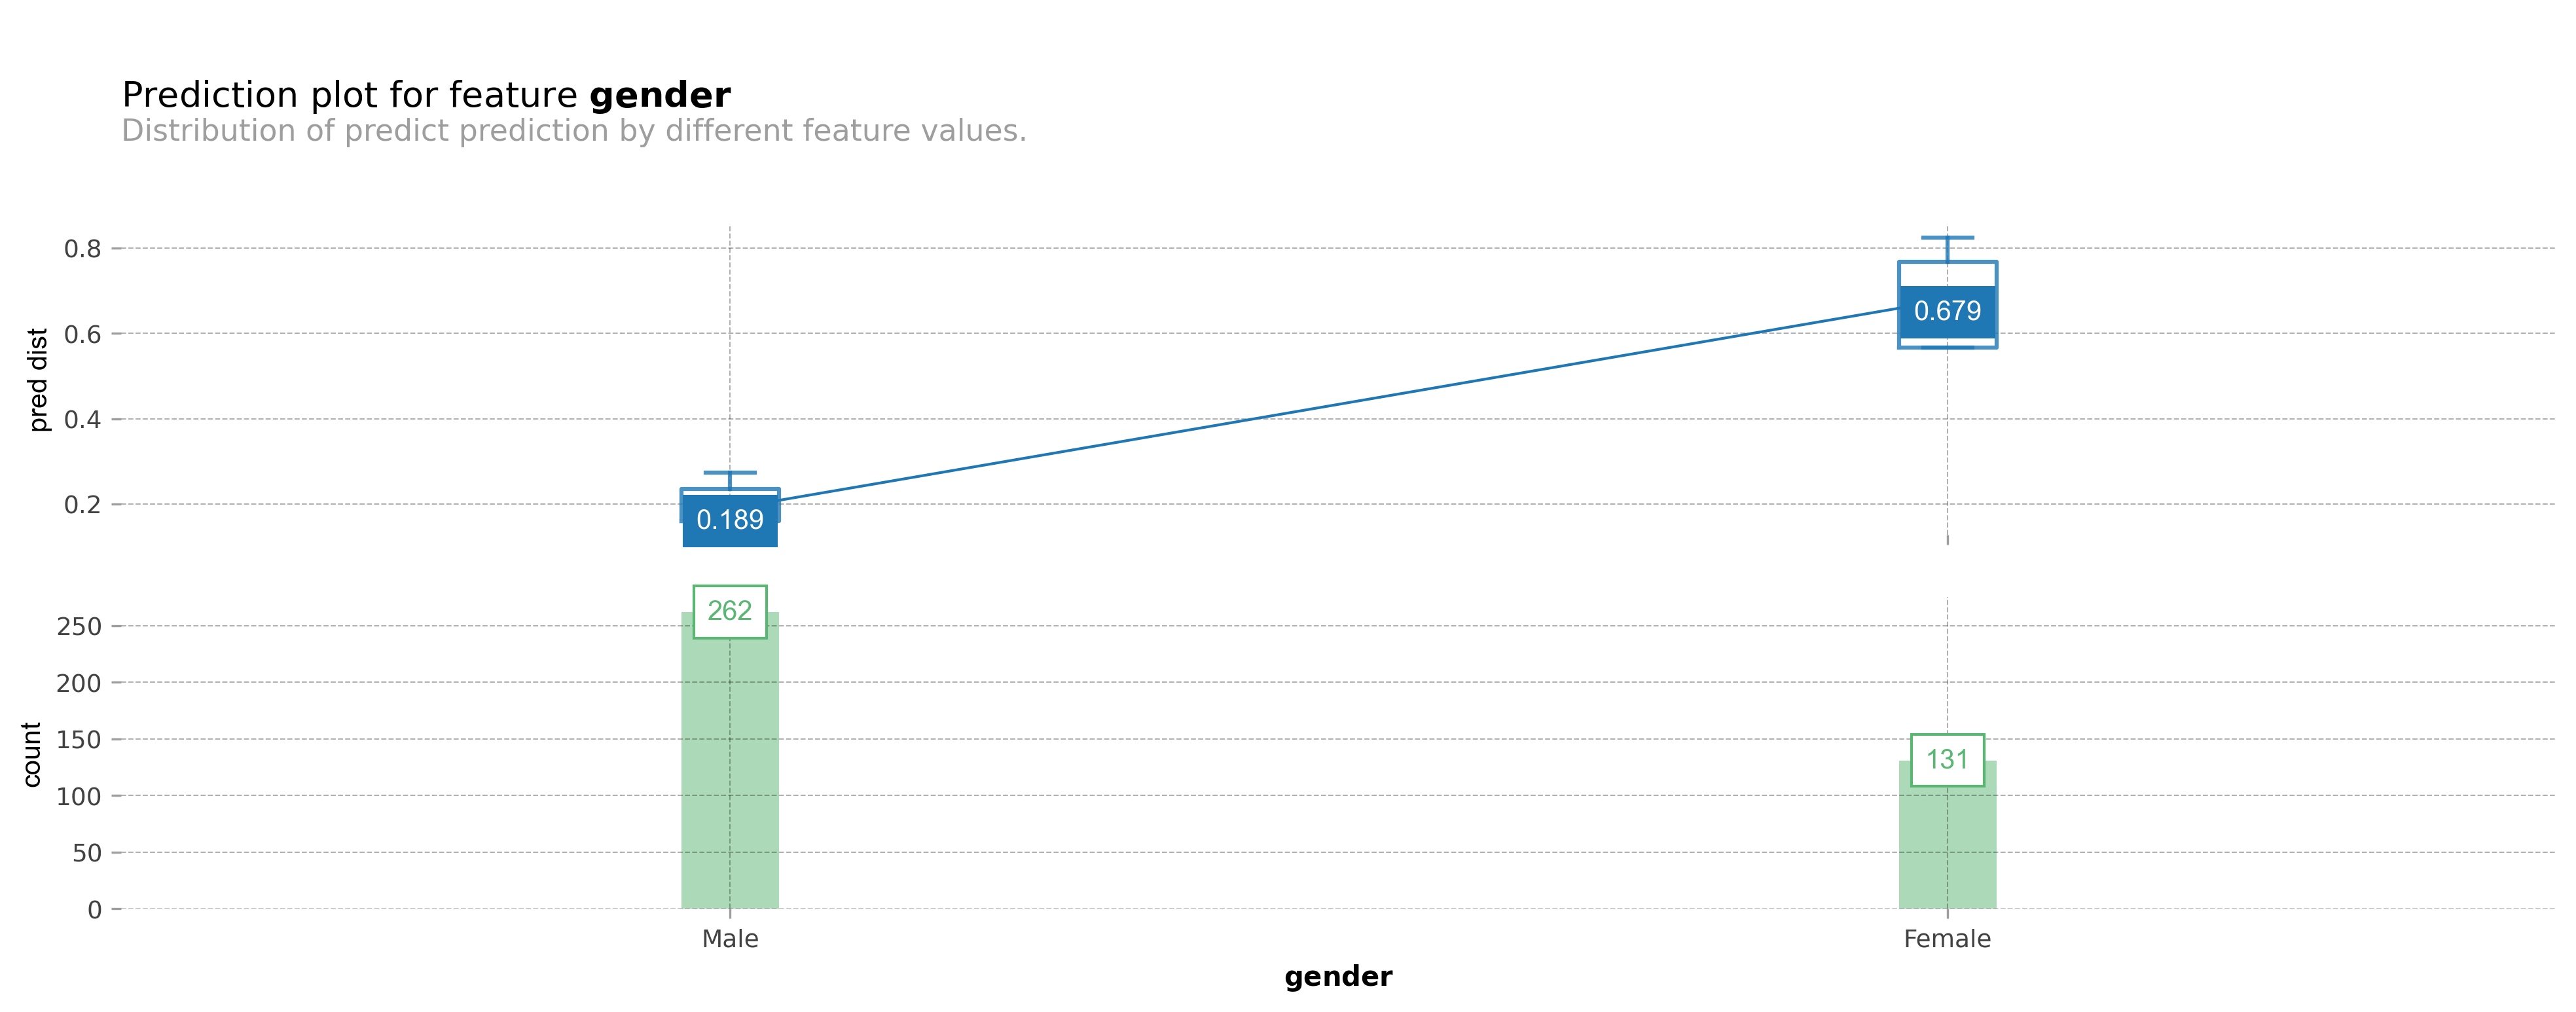

In [33]:
# we use the object above to generate the plot
fig, axes, summary_df = predict_plot_gender.plot(
    engine='matplotlib',
);
fig.set_figheight(6)

# we can change the names of the feature values
_ = axes['bar_axes'][0].set_xticklabels(['Male', 'Female'])

 - The above plot is 2 stacked plots:
     - A count plot that shows the distribution of the variable gender
     - A Prediction Distribution showing the model probabilities in a box plot for each of the variable categories.

In [34]:
# the plot also provides the data that generated the plot
summary_df

,x,value,count,pred_q1,pred_q2,pred_q3
0,0,sex_female_0,262,0.160058,0.188649,0.235628
1,1,sex_female_1,131,0.566461,0.678836,0.768690


#### Target Plot


 - From the documentation of Target Plot:
    - Generates plots displaying the average values of target variables across distinct groups (or buckets) of a single feature.
    - These plots provide insights into how the target’s average values change with respect to the different groups of a chosen feature.
    - This understanding is crucial for comprehensive feature analysis and facilitates the interpretation of model predictions.
    - documentation link: https://pdpbox.readthedocs.io/en/latest/TargetPlot.html

In [35]:
target_plot_gender = info_plots.TargetPlot(
    df=pd.concat([X_test, y_test], axis=1),
    feature="sex_female",
    feature_name="gender",
    target=y_test.name,
)

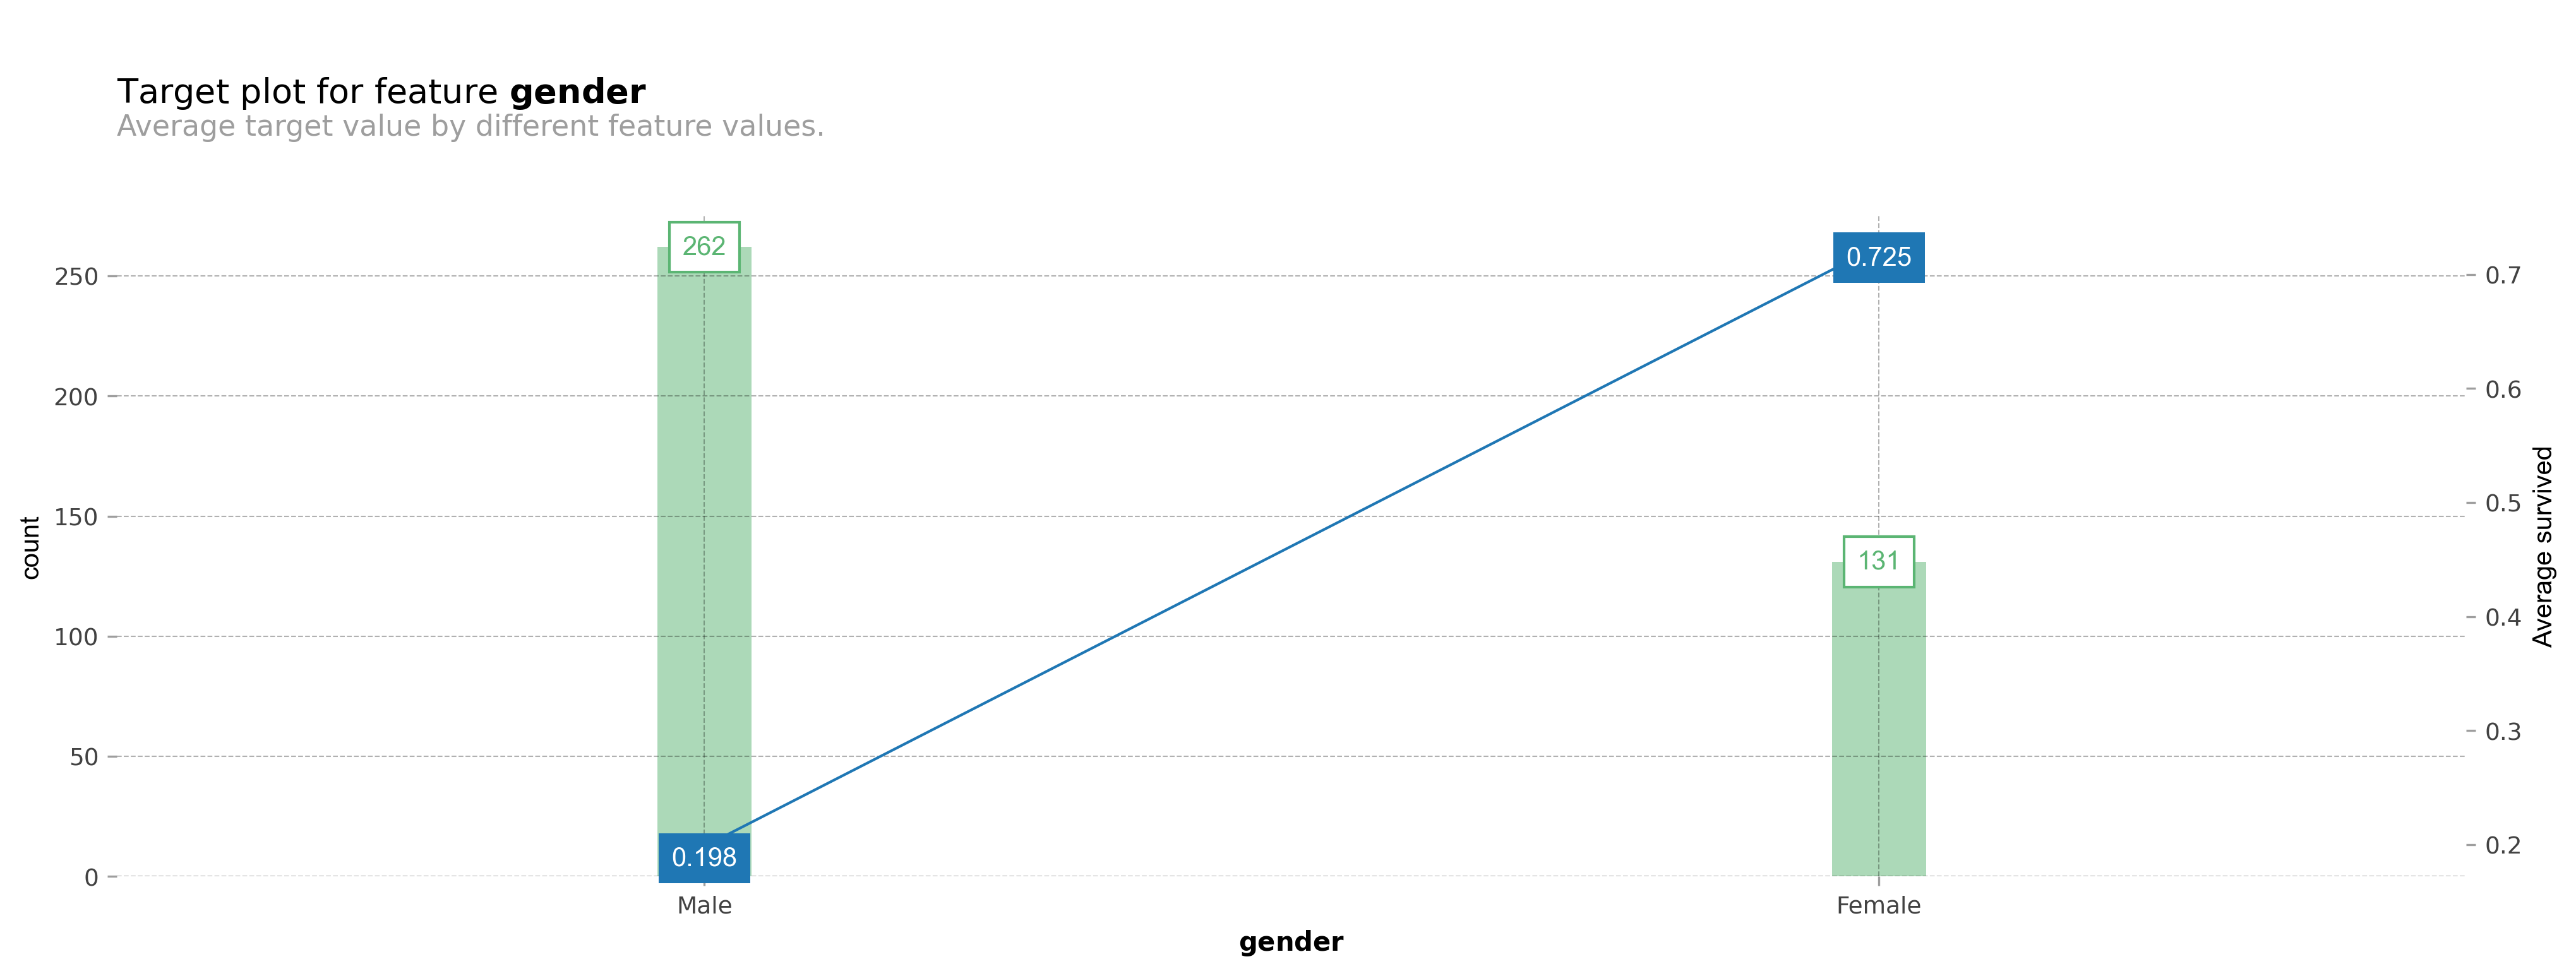

In [36]:
fig, axes, summary_df = target_plot_gender.plot(
    engine='matplotlib',
);
fig.set_figheight(6)

# we can change the names of the feature values
_ = axes['bar_axes'][0].set_xticklabels(['Male', 'Female'])

- The above plot documents:
     - The count of each category of the variable of interest(green bars)
     - The mean of the Target variable (Survived) in each of the categories (blue)